In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
zip_file = '/content/homer_bart_1.zip'

z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
print(os.listdir('/content/homer_bart_1'))

['homer69.bmp', 'bart77.bmp', 'homer16.bmp', 'bart60.bmp', 'bart35.bmp', 'bart127.bmp', 'homer115.bmp', 'bart124.bmp', 'bart141.bmp', 'bart23.bmp', 'bart72.bmp', 'homer82.bmp', 'homer92.bmp', 'homer73.bmp', 'bart146.bmp', 'homer68.bmp', 'bart27.bmp', 'homer37.bmp', 'bart138.bmp', 'bart8.bmp', 'bart143.bmp', 'bart67.bmp', 'bart40.bmp', 'homer24.bmp', 'bart116.bmp', 'homer41.bmp', 'homer124.bmp', 'bart83.bmp', 'bart111.bmp', 'bart90.bmp', 'bart103.bmp', 'homer78.bmp', 'homer100.bmp', 'homer84.bmp', 'bart91.bmp', 'bart110.bmp', 'bart168.bmp', 'homer20.bmp', 'bart29.bmp', 'homer1.bmp', 'bart4.bmp', 'bart51.bmp', 'bart53.bmp', 'bart136.bmp', 'bart7.bmp', 'bart61.bmp', 'homer85.bmp', 'bart34.bmp', 'homer74.bmp', 'bart38.bmp', 'bart81.bmp', 'bart56.bmp', 'homer72.bmp', 'bart135.bmp', 'bart42.bmp', 'bart99.bmp', 'homer60.bmp', 'bart132.bmp', 'homer90.bmp', 'bart20.bmp', 'bart133.bmp', 'homer65.bmp', 'bart73.bmp', 'homer2.bmp', 'bart6.bmp', 'bart120.bmp', 'bart144.bmp', 'homer99.bmp', 'homer63.

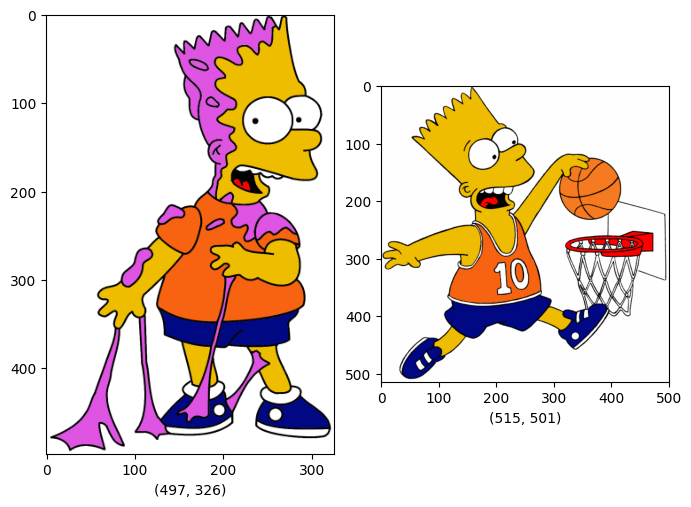

In [ ]:
plt.figure(figsize=(7,7))
for i in range(2):
  plt.subplot(1,2,i+1)
  img = plt.imread(f"/content/homer_bart_1/bart{i+1}.bmp")
  plt.tight_layout()
  plt.imshow(img)
  plt.xlabel(img.shape[:2])

Размеры изображений в сете неодинаковые, поэтомы изменим их.

In [ ]:
import cv2

In [ ]:
height = 128
width = 128

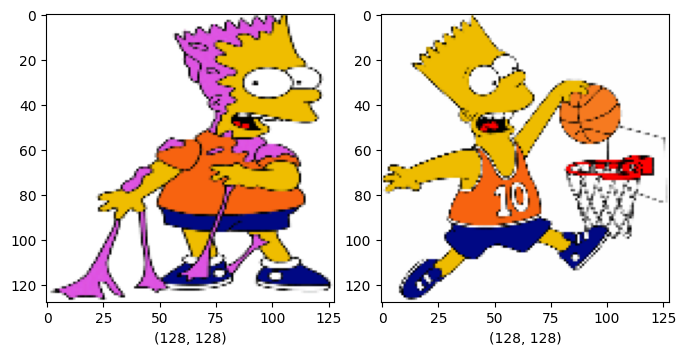

In [ ]:
plt.figure(figsize=(7,7))
for i in range(2):
  plt.subplot(1,2,i+1)
  img = plt.imread(f"/content/homer_bart_1/bart{i+1}.bmp")
  img_resized = cv2.resize(img, (height, width))
  plt.tight_layout()
  plt.imshow(img_resized)
  plt.xlabel(img_resized.shape[:2])

In [ ]:
images = []
labels = []
class_labels = ['Homer', 'Bart']

for filename in (os.listdir('/content/homer_bart_1')):
  img = plt.imread(f"/content/homer_bart_1/{filename}")
  img_resized = cv2.resize(img, (height, width))
  images.append(img_resized)

  if filename.startswith('homer'):
    labels.append(0)
  elif filename.startswith('bart'):
    labels.append(1)

images = np.array(images).astype('float32') / 255.0
labels = np.array(labels)

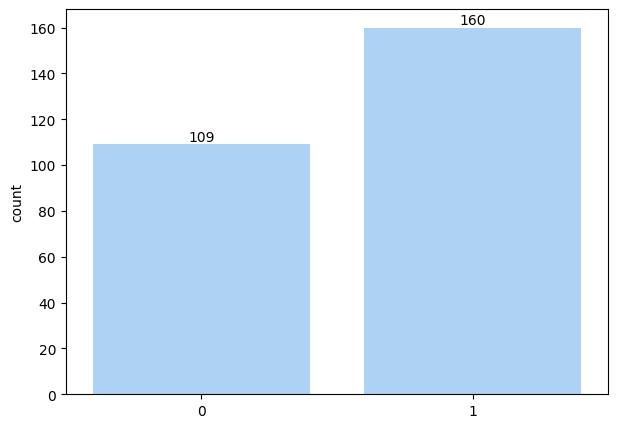

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=labels, color='#a2d2ff')
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(228, 128, 128, 3) (41, 128, 128, 3) (228,) (41,)


In [ ]:
print(f'Homer train labels: {sum(y_train == 0)}\nBart train labels: {sum(y_train == 1)}')
print(f'\nHomer test labels: {sum(y_test == 0)}\nBart test labels: {sum(y_test == 1)}')

Homer train labels: 92
Bart train labels: 136

Homer test labels: 17
Bart test labels: 24


Так как классы для тренировочной выборки не сбалансированы, сбалансируем данные с помощью RandomUnderSampler - уменьшим выборку большинства классов случайным отбором.

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rus = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train_reshaped, y_train)

print(f'Homer train labels: {sum(y_train_rus == 0)}\nBart train labels: {sum(y_train_rus == 1)}')
print(f'X_train shape: {X_train_rus.shape}; y_train shape: {y_train_rus.shape}')

Homer train labels: 92
Bart train labels: 92
X_train shape: (184, 49152); y_train shape: (184,)


In [ ]:
y_train = y_train_rus

return_shape = list(X_train.shape)
return_shape[0] = X_train_rus.shape[0]
X_train = X_train_rus.reshape(return_shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(184, 128, 128, 3) (41, 128, 128, 3) (184,) (41,)


In [ ]:
optimization = pd.DataFrame(columns=['optimization', 'accuracy'])

# TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow import keras

## Hyperopt

In [ ]:
import hyperopt
from hyperopt import fmin, tpe, hp
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

In [ ]:
def get_model(params):
  model = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(params['hidden_layer'], activation='relu'),
      Dense(2, activation='softmax')
    ])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=params['learning_rate']),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=0)
  val_accuracy = history.history['val_accuracy'][-1]

  return -val_accuracy  # минимизация, тк Hyperopt ищет минимум функции

In [ ]:
params = {
    'hidden_layer': hp.choice('hidden_layer', [32, 64, 128, 256, 512, 1024, 2048, 4096]),
    'learning_rate': hp.loguniform('learning_rate', -5, -1)
}

In [ ]:
best = fmin(fn=get_model,
            space=params,
            algo=tpe.suggest,
            max_evals=10)  # кол-во экспериментов

100%|██████████| 10/10 [13:38<00:00, 81.82s/trial, best loss: -0.7560975551605225]


In [ ]:
best

{'hidden_layer': 6, 'learning_rate': 0.011069493595806742}

In [ ]:
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(2048, activation='relu'),
    Dense(2, activation='softmax')
    ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.011069493595806742),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 [==============================] - 0s 96ms/step - loss: 1.7025 - accuracy: 0.7561
Accuracy of test images: 75.61%


In [ ]:
opt = {'optimization': 'Hyperopt', 'accuracy': f"{test_acc * 100:.2f}%"}
optimization = pd.concat([optimization, pd.DataFrame([opt])], ignore_index=True)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 [==============================] - 1s 136ms/step
Confusion Matrix:
[[14  3]
 [ 7 17]]


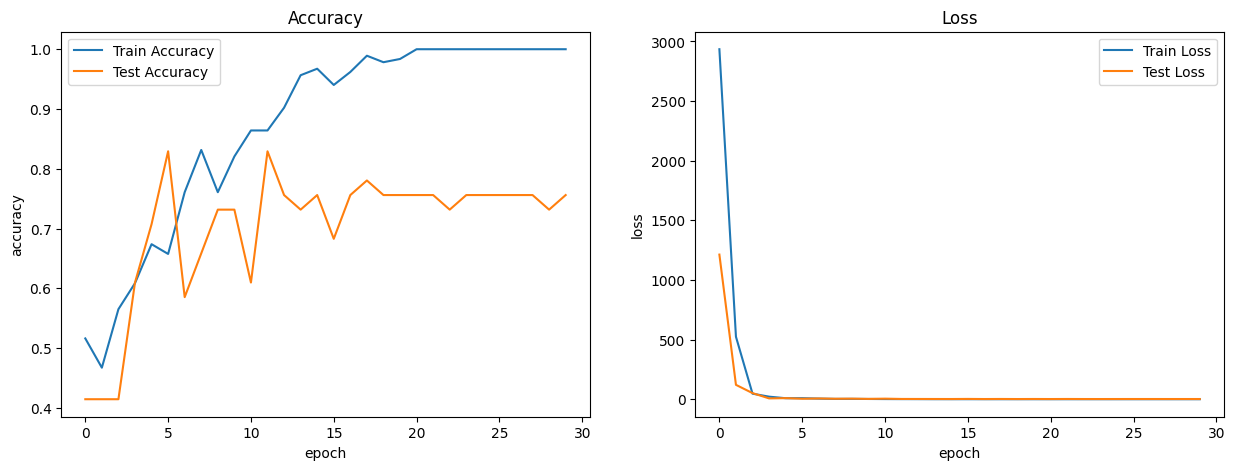

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## GridSearch

In [ ]:
!pip install scikeras

In [ ]:
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
def create_model(hidden_layer, learning_rate):
  model = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(hidden_layer, activation='relu'),
      Dense(2, activation='softmax')
    ])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
model = KerasClassifier(create_model, hidden_layer=32, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4707 - loss: 273.6442


KerasClassifier(
	model=<function create_model at 0x7f3afeeb75b0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	hidden_layer=32
	learning_rate=0.01
	class_weight=None
)

In [ ]:
param_grid = {
    'hidden_layer': [32, 64, 256, 512, 1024],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_, grid_result.best_params_)

0.5162171690463598 {'hidden_layer': 256, 'learning_rate': 0.01}


In [ ]:
model_grid = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(256, activation='relu'),
      Dense(2, activation='softmax')
    ])

model_grid.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history = model_grid.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model_grid.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7541 - loss: 6.9766
Accuracy of test images: 75.61%


In [ ]:
opt = {'optimization': 'GridSearch', 'accuracy': f"{test_acc * 100:.2f}%"}
optimization = pd.concat([optimization, pd.DataFrame([opt])], ignore_index=True)

In [ ]:
y_pred = model_grid.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confusion Matrix:
[[12  5]
 [ 5 19]]


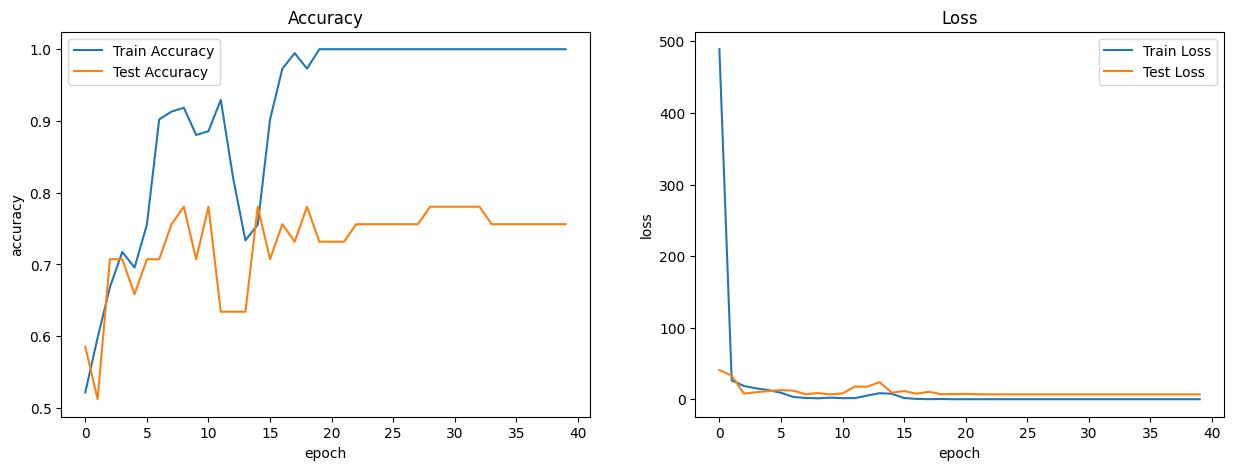

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params_random = {
    'hidden_layer': [32, 64, 256, 512, 1024, 2048],
    'learning_rate': [0.001, 0.01, 0.1]
}

rs = RandomizedSearchCV(estimator=model, param_distributions=params_random, refit=False, cv=3, scoring='accuracy')
rs_result = rs.fit(X_train, y_train)

In [ ]:
print(rs_result.best_score_, rs_result.best_params_)

0.543010752688172 {'learning_rate': 0.1, 'hidden_layer': 512}


In [ ]:
model_rs = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(512, activation='relu'),
      Dense(2, activation='softmax')
    ])

model_rs.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history = model_rs.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model_rs.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7274 - loss: 1.2935
Accuracy of test images: 73.17%


In [ ]:
opt = {'optimization': 'RandomizedSearch', 'accuracy': f"{test_acc * 100:.2f}%"}
optimization = pd.concat([optimization, pd.DataFrame([opt])], ignore_index=True)

In [ ]:
y_pred = model_rs.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Confusion Matrix:
[[13  4]
 [ 7 17]]


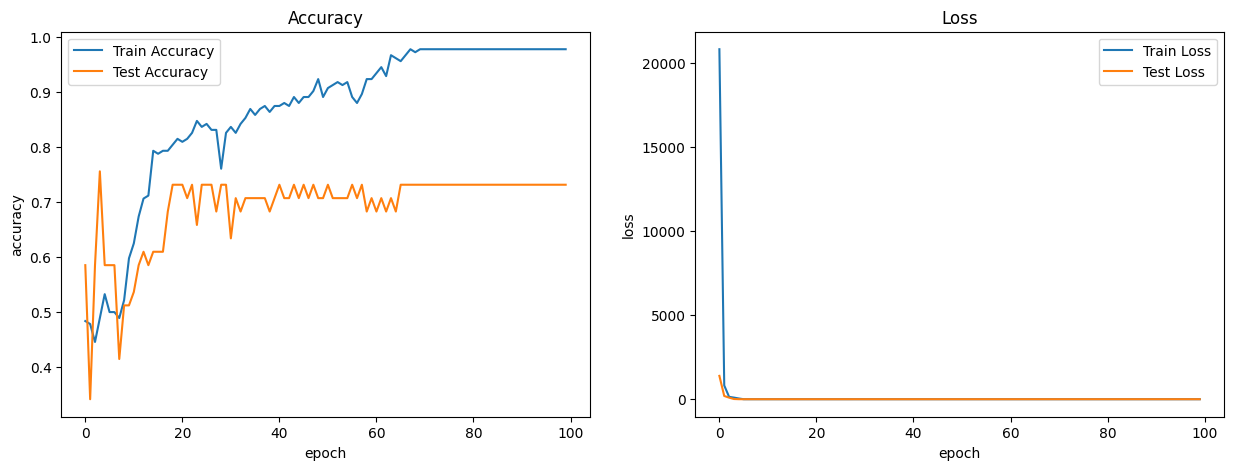

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
def objective(trial):
    neurons = trial.suggest_categorical('neurons', [32, 64, 128, 256, 512, 1024, 2048])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(neurons, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

In [ ]:
study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=10)

[I 2024-05-30 15:14:29,170] A new study created in memory with name: no-name-8a3f8633-f28e-4954-abe6-61459c4de79b
[I 2024-05-30 15:17:11,403] Trial 0 finished with value: 0.7560975551605225 and parameters: {'neurons': 2048, 'learning_rate': 0.0002336022502443321}. Best is trial 0 with value: 0.7560975551605225.
[I 2024-05-30 15:17:45,840] Trial 1 finished with value: 0.7317073345184326 and parameters: {'neurons': 512, 'learning_rate': 0.00751570050803416}. Best is trial 0 with value: 0.7560975551605225.
[I 2024-05-30 15:20:36,956] Trial 2 finished with value: 0.7560975551605225 and parameters: {'neurons': 2048, 'learning_rate': 0.0025166418374986486}. Best is trial 0 with value: 0.7560975551605225.
[I 2024-05-30 15:21:11,646] Trial 3 finished with value: 0.6829268336296082 and parameters: {'neurons': 512, 'learning_rate': 0.00045194767556647685}. Best is trial 0 with value: 0.7560975551605225.
[I 2024-05-30 15:23:37,593] Trial 4 finished with value: 0.7317073345184326 and parameters: {

In [ ]:
print('Best parameters:', study.best_params)
print('Accuracy: {:.2f}%'.format(study.best_value * 100))

Best parameters: {'neurons': 128, 'learning_rate': 0.00012219406026185047}
Accuracy: 78.05%


In [ ]:
model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00012219406026185047),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7541 - loss: 0.5518
Accuracy of test images: 75.61%


In [ ]:
opt = {'optimization': 'Optuna', 'accuracy': f"{test_acc * 100:.2f}%"}
optimization = pd.concat([optimization, pd.DataFrame([opt])], ignore_index=True)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Confusion Matrix:
[[13  4]
 [ 6 18]]


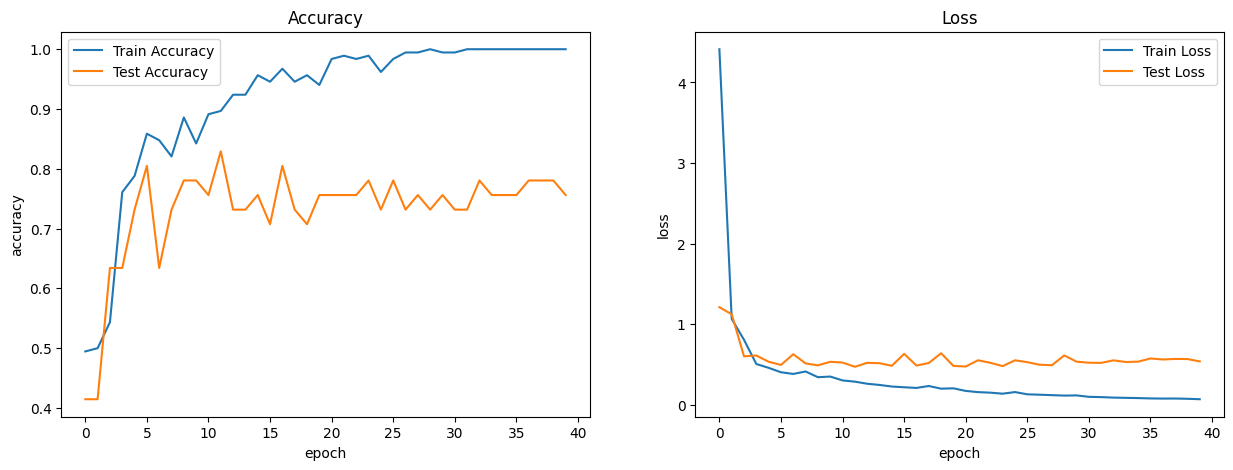

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## BayesianOptimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def bayes_opt(neurons, learning_rate):
    model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(int(neurons), activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=5, validation_split=0.1, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

In [ ]:
params_bayes_opt = {
    'neurons': (24, 2048),
    'learning_rate': (1e-4, 1e-2)
    }

optimizer = BayesianOptimization(f=bayes_opt, pbounds=params_bayes_opt, verbose=2, random_state=10)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | learni... |  neurons  |
-------------------------------------------------
| 1         | 0.0       | 0.007736  | 66.0      |
| 2         | 0.0       | 0.006373  | 1.54e+03  |
| 3         | 1.0       | 0.005035  | 479.0     |
| 4         | 1.0       | 0.002061  | 1.563e+03 |
| 5         | 1.0       | 0.001774  | 202.8     |
| 6         | 1.0       | 0.001488  | 1.565e+03 |
| 7         | 0.0       | 0.005374  | 500.7     |
| 8         | 1.0       | 0.004974  | 464.1     |
| 9         | 0.5789    | 0.007795  | 222.7     |
| 10        | 1.0       | 0.0001877 | 184.8     |
| 11        | 0.1579    | 0.0006657 | 161.5     |
| 12        | 0.6842    | 0.003713  | 442.6     |
| 13        | 0.8421    | 0.005647  | 1.591e+03 |
| 14        | 0.1579    | 0.008709  | 1.615e+03 |
| 15        | 0.0       | 0.006379  | 406.2     |


In [ ]:
print('Best parameters:', optimizer.max['params'])
print('Best validation accuracy:', optimizer.max['target'])

Best parameters: {'learning_rate': 0.005035219421795646, 'neurons': 478.9884105544357}
Best validation accuracy: 1.0


In [ ]:
model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(int(478.9884105544357), activation='relu'),
        Dense(2, activation='softmax')
    ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005035219421795646),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7274 - loss: 5.1718
Accuracy of test images: 73.17%


In [ ]:
opt = {'optimization': 'BayesianOptimization', 'accuracy': f"{test_acc * 100:.2f}%"}
optimization = pd.concat([optimization, pd.DataFrame([opt])], ignore_index=True)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Confusion Matrix:
[[14  3]
 [ 8 16]]


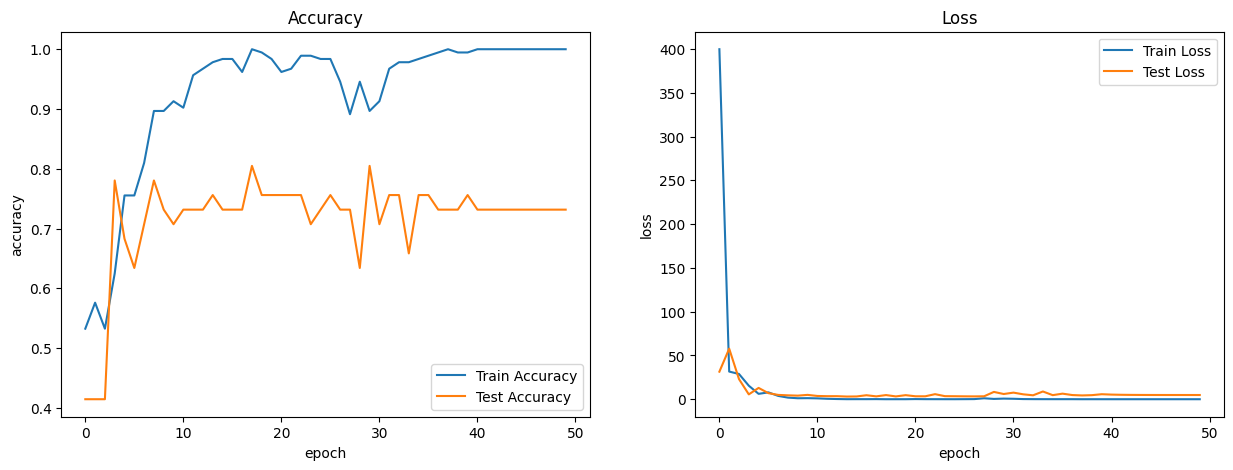

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [ ]:
optimization

,optimization,accuracy
0,Hyperopt,75.61%
1,GridSearch,75.61%
2,RandomizedSearch,73.17%
3,Optuna,75.61%
4,BayesianOptimization,73.17%


Одинаковые результаты получились у сетей с использованием следующих методов подбора гиперпараметров - Hyperopt, GridSearch и Optuna.